# Работа с текстом 2

1. Предварительная обработка данных:

In [3]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
import torch
import faiss
from tqdm import tqdm
from collections import Counter

In [2]:
!pip install faiss-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 6.8 MB/s eta 0:00:00


In [6]:
# Загрузка данных из предоставленных файлов
train_data = pd.read_csv("/dataset_train.tsv", sep="\t", header=None, names=["text", "label"])
test_data = pd.read_csv("/dataset_test.tsv", sep="\t", header=None, names=["text", "label"])

# Проверим первые несколько строк, чтобы понять структуру данных
train_data.head(), test_data.head()

(                         text              label
 0           мне нужна справка  statement_general
 1            оформить справку  statement_general
 2               взять справку  statement_general
 3        справку как получить  statement_general
 4  справку ммф где получаться  statement_general,
                                    text              label
 0                  как получить справку  statement_general
 1                     мне нужна справка  statement_general
 2              справка студента эф петь            conform
 3         справка студента фф оформлять            conform
 4  как мне заказать справка об обучении            conform)

In [7]:
# Загрузка токенизатора и модели DistilBERT-like из Hugging Face
model_name = "distilbert-base-multilingual-cased"  # Легкая модель для уменьшения нагрузки
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Используем CPU для избегания проблем с перегрузкой GPU
device = torch.device("cpu")

# Функция для преобразования текста в эмбеддинги и сохранение их порциями
def save_embeddings_in_batches(texts, model, batch_size=2, max_length=64, output_file="train_embeddings.npy"):
    model = model.to(device)
    model.eval()

    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=max_length).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()

        # Сохраняем сразу в файл, не держа всё в памяти
        if i == 0:
            np.save(output_file, batch_embeddings)
        else:
            with open(output_file, 'ab') as f:
                np.save(f, batch_embeddings)

        # Освобождение ресурсов
        del inputs, outputs, batch_embeddings
        torch.cuda.empty_cache()

    print(f"Сохранение эмбеддингов завершено.")

# Загрузка модели один раз и сохранение эмбеддингов
model = AutoModel.from_pretrained(model_name).to(device)
save_embeddings_in_batches(train_data['text'].tolist(), model, batch_size=2, max_length=64, output_file="train_embeddings.npy")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

100%|██████████| 6615/6615 [07:26<00:00, 14.82it/s]

Сохранение эмбеддингов завершено.


2. Генерация эмбеддингов для всего обучающего набора данных

In [8]:
# Загрузка эмбеддингов из файла для дальнейшего использования
def load_embeddings_from_file(filepath):
    embeddings = []
    with open(filepath, 'rb') as f:
        while True:
            try:
                embeddings.append(np.load(f))
            except EOFError:
                break
    return np.vstack(embeddings)

In [9]:
train_embeddings_np = load_embeddings_from_file("train_embeddings.npy").astype('float32')

3. Построение индекса с использованием FAISS

In [10]:
# Создание индекса FAISS для L2 (евклидовой) метрики
dimension = train_embeddings_np.shape[1]
index = faiss.IndexFlatL2(dimension)

# Добавляем эмбеддинги в индекс порциями
for i in range(0, len(train_embeddings_np), 500):
    index.add(train_embeddings_np[i:i+500])

print(f"Количество добавленных в индекс эмбеддингов: {index.ntotal}")

Количество добавленных в индекс эмбеддингов: 13230


4. Классификация новых данных с использованием KNN

In [11]:
# Функция для преобразования текста в эмбеддинги (которая использовалась в classify_text)
def get_embeddings(texts, model, batch_size=1, max_length=64):
    model = model.to(device)
    model.eval()
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=max_length).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
    return embeddings

In [12]:
# Функция для классификации нового текста с использованием KNN
def classify_text(text, k=1):
    # Используем уже загруженную модель и токенизатор
    text_embedding = get_embeddings([text], model, batch_size=1, max_length=64).astype('float32')

    D, I = index.search(text_embedding, k)
    nearest_labels = train_data['label'].iloc[I[0]].values

    if k == 1:
        return nearest_labels[0]
    else:
        return Counter(nearest_labels).most_common(1)[0][0]

# Пример классификации тестового текста
test_text = test_data['text'].iloc[0]
predicted_label = classify_text(test_text, k=3)
print(f"Предсказанная метка: {predicted_label}")

Предсказанная метка: statement_general


5. Проверяе точность модели

In [13]:
# Оценка точности модели на тестовых данных
predicted_labels = [classify_text(text, k=3) for text in test_data['text'].tolist()]
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_data['label'], predicted_labels)
print(f"Точность модели: {accuracy * 100:.2f}%")

Точность модели: 89.13%


In [14]:
# Просмотр первых 10 примеров предсказаний и их реальных меток
for i in range(10):
    text = test_data['text'].iloc[i]
    real_label = test_data['label'].iloc[i]
    predicted_label = classify_text(text, k=3)
    print(f"Текст: {text}")
    print(f"Реальная метка: {real_label} | Предсказанная метка: {predicted_label}\n")

Текст: как получить справку
Реальная метка: statement_general | Предсказанная метка: statement_general

Текст: мне нужна справка
Реальная метка: statement_general | Предсказанная метка: statement_general

Текст: справка студента эф петь
Реальная метка: conform | Предсказанная метка: conform

Текст: справка студента фф оформлять
Реальная метка: conform | Предсказанная метка: conform

Текст: как мне заказать справка об обучении
Реальная метка: conform | Предсказанная метка: conform

Текст: справка студента фит оформить
Реальная метка: conform | Предсказанная метка: conform

Текст: справка студента как мне заказать
Реальная метка: conform | Предсказанная метка: conform

Текст: справка об обучении получать
Реальная метка: conform | Предсказанная метка: conform

Текст: справка студента ммф оформлять
Реальная метка: conform | Предсказанная метка: conform

Текст: справка о обучении как мне заказать
Реальная метка: conform | Предсказанная метка: conform



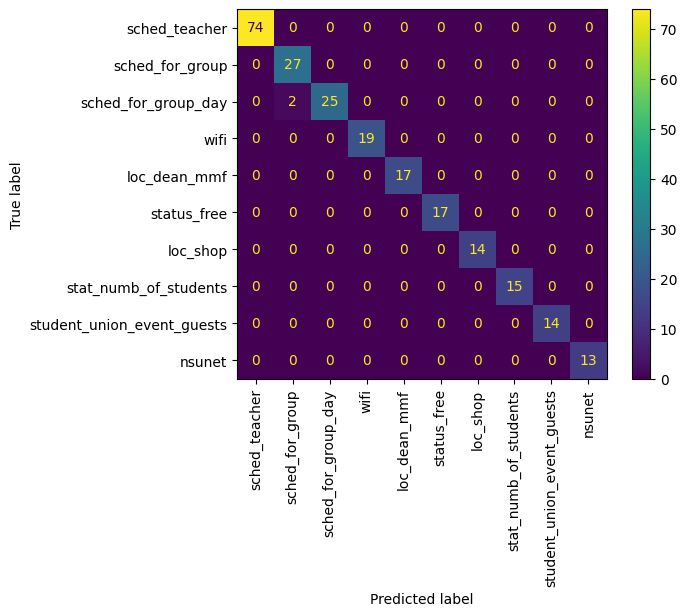

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Выбираем несколько меток для анализа
selected_classes = test_data['label'].value_counts().index[:10]  # Самые частые 10 меток

# Фильтруем тестовые данные и предсказания только для этих меток
filtered_indices = test_data['label'].isin(selected_classes)
filtered_true = test_data['label'][filtered_indices]
filtered_predicted = np.array(predicted_labels)[filtered_indices]

# Строим матрицу ошибок только для выбранных классов
cm = confusion_matrix(filtered_true, filtered_predicted, labels=selected_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=selected_classes)
disp.plot(xticks_rotation='vertical')